cpu
Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
Already up to date.
going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
OurConvLSTM_ts_0_val_4: 12.536280632019043


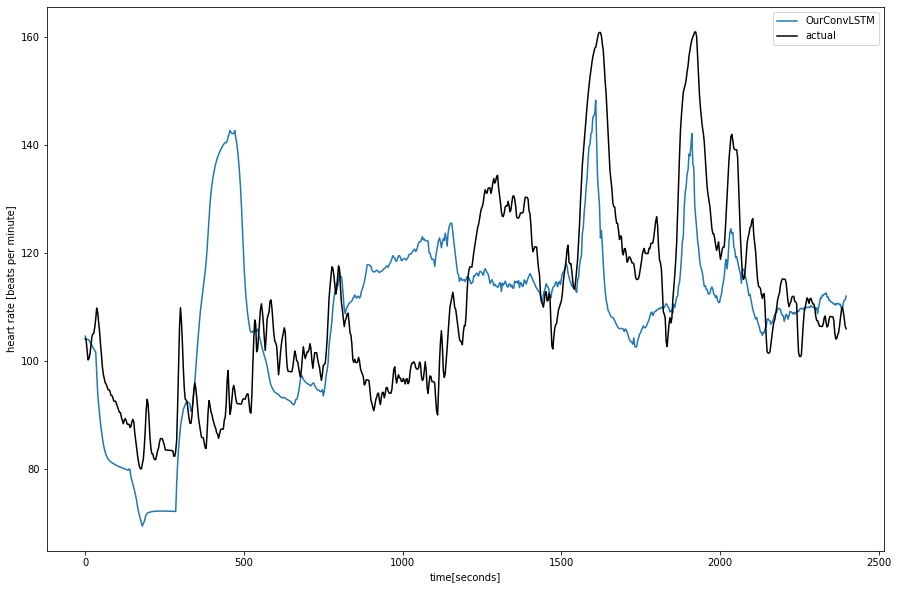

Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
Already up to date.
going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
OurConvLSTM_ts_2_val_4: 14.488696098327637


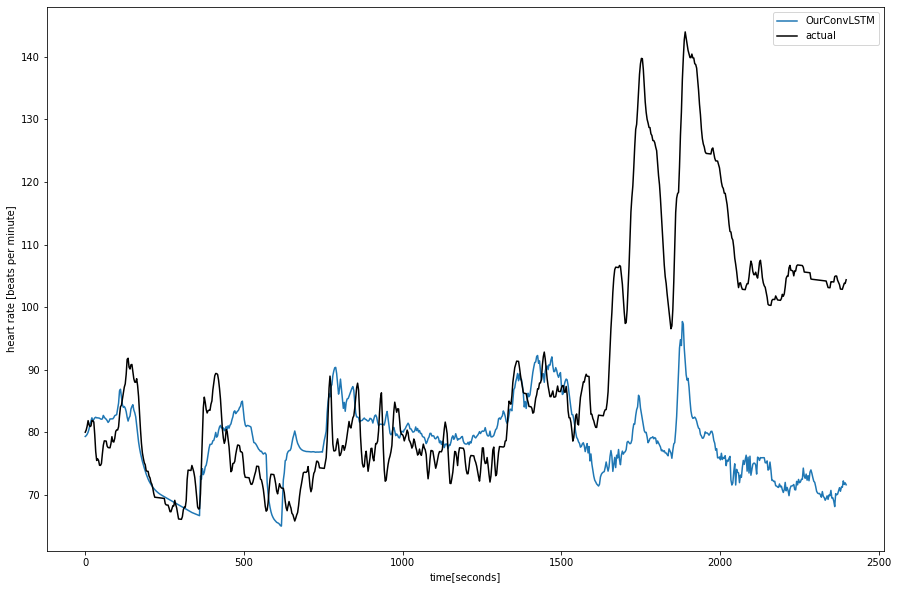

Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
Already up to date.
going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
OurConvLSTM_ts_3_val_4: 20.463972091674805


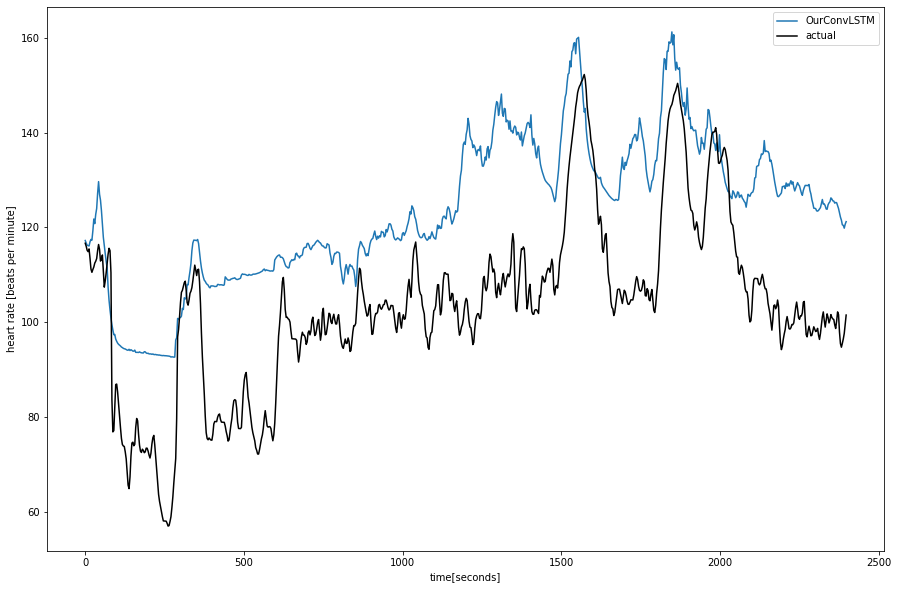

Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
Already up to date.
going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
OurConvLSTM_ts_5_val_4: 15.880014419555664


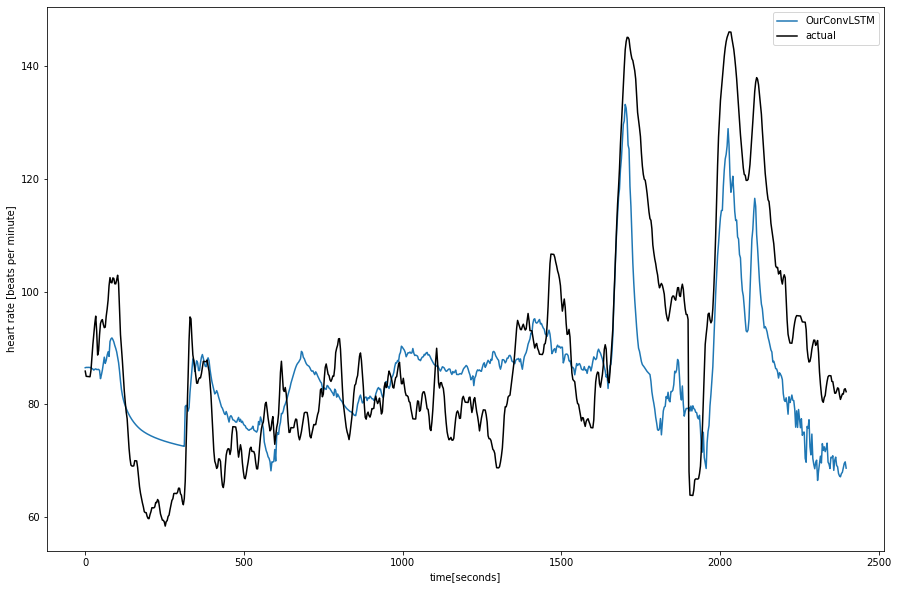

Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
Already up to date.
going to push
Already up to date.
/content
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


RuntimeError: ignored

In [1]:

#%%
import torch

args = {
    'epoch_num': 100,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'batch_size': 5,     # Mini-batch size. 600
    'batch_test': 5,     # size of test batch
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

dataset_name = "PAMAP2"
model_type = "OurConvLSTM"
#"OurConvLSTM", "AttentionTransformer", "DeepConvLSTM", "CnnIMU", FCNN

val_sub = 4
for ts_sub in [0,2,3,5,6,7]:##,1,3,5,0]:#2,6]:#[6,7,2,0,1,3,5]:


  ! pip install wget
  import os
  import torch
  import pandas as pd
  import numpy as np
  import torch
  from torch import nn


  ssh_config = """
  Host github.com
    IdentityFile ~/.ssh/github.pem
    User davipeag
    StrictHostKeyChecking no
  """

  if os.name == 'nt':
    base_path = ""
    REPO_DIR = "."
    STORE_DIR ="." 
    print("Windows")
  else:
    print("Unix-like")
    REPO_DIR = "/tmp/HeartRateRegression"
    from google.colab import drive
    drive.mount('/content/drive')
    GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
    DATA_PATH = "/content/drive/My\ Drive/deeplearning_project/normalized.zip"
    STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
    !mkdir ~/.ssh
    !cp -u {GIT_PATH} ~/.ssh/
    !chmod u=rw,g=,o= ~/.ssh/github.pem
    !echo "{ssh_config}" > ~/.ssh/config
    !chmod u=rw,g=,o= ~/.ssh/config
    ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
    ! (cd {REPO_DIR} && git pull )
    import sys
    sys.path.append(REPO_DIR)


  def git_push():
    if os.name == 'nt':
      pass
    else:
      ! git config --global user.email "daviaguiar@outlook.com"
      ! git config --global user.name "Davi Pedrosa de Aguiar"
      print("going to push")
      ! (cd {REPO_DIR} && git pull && cd -)
      ! (cd {REPO_DIR} && git add . && git commit -m "from colab" && git push)

  def git_pull():
    if os.name == 'nt':
      pass
    else:
      ! git config --global user.email "daviaguiar@outlook.com"
      ! git config --global user.name "Davi Pedrosa de Aguiar"
      print("going to push")
      ! (cd {REPO_DIR} && git pull && cd -)
      
    
  git_push()



  from data_utils import (
      Pamap2Handler, cross_validation_split)

  from default_utils import DefaultPamapPreprocessing, FcPamapPreprocessing
  from preprocessing_utils import (OurConvLstmToAttentionFormat, OurConvLstmToCnnImuFormat)

  from models_utils import OurConvLstmDataset, make_loader, reset_seeds
  from models_utils import DatasetXY

  from default_utils import TrainOurConvLSTM, TrainXY
  from default_utils import make_our_conv_lstm, make_attention_transormer_model, make_fcnn
  from torch import nn



  reset_seeds()

  is_size = 2 
  recursive_size = 800
  total_size = recursive_size + is_size

  ##%%

  dataset_handler = Pamap2Handler(os.path.join(REPO_DIR, ".."))

  #dfs = [dataset_handler.get_protocol_subject(s) for s in [1,2,3,4,5,6,7,8,9]]
  df_ts = dataset_handler.get_protocol_subject(ts_sub + 1)
  #df_full = pd.concat(dfs)

  #use_dfs = dfs[0:8]

  # preprocessing_options = {
  #     "OurConvLSTM": DefaultPamapPreprocessing(ts_count = 300, donwsampling_ratio = 1),
  #     "AttentionTransformer": DefaultPamapPreprocessing(
  #       ts_count = 300, donwsampling_ratio = 1, last_transformer=OurConvLstmToAttentionFormat()),
  #     "DeepConvLSTM": DefaultPamapPreprocessing(last_transformer=OurConvLstmToCnnImuFormat()),
  #     "CnnIMU": DefaultPamapPreprocessing(last_transformer=OurConvLstmToCnnImuFormat()),
  #     "FCNN": FcPamapPreprocessing(),
  # }

  preprocessing_options = {
    "OurConvLSTM": DefaultPamapPreprocessing(ts_count = 300, donwsampling_ratio = 1, ts_per_sample=total_size),
    "AttentionTransformer": DefaultPamapPreprocessing(
        ts_count = 300, donwsampling_ratio = 1, ts_per_sample=total_size, last_transformer=OurConvLstmToAttentionFormat()),
    "DeepConvLSTM": DefaultPamapPreprocessing(ts_per_sample=total_size, last_transformer=OurConvLstmToCnnImuFormat()),
    "CnnIMU": DefaultPamapPreprocessing(ts_per_sample=total_size, last_transformer=OurConvLstmToCnnImuFormat()),
    "FCNN": FcPamapPreprocessing(ts_per_sample=total_size),
 }



  preprocessor =preprocessing_options[model_type]

  ##%%

  #preprocessor.transformers.fit(df_full)
  #xy_tr, xy_val, xy_ts = cross_validation_split(dfs, preprocessor.transformers, preprocessor.transformers_ts, preprocessor.transformers_ts, val_sub, ts_sub)

  xy_ts = [preprocessor.transformers_ts.transform(df_ts)]

  # del dfs
  # del df_full
  # del use_dfs

  dataset_cls_options = {
      "OurConvLSTM": OurConvLstmDataset,
      "AttentionTransformer": DatasetXY,
      "DeepConvLSTM": DatasetXY,
      "CnnIMU": DatasetXY,
      "FCNN": DatasetXY,
  }


  dataset_cls = dataset_cls_options[model_type]

  #loader_tr = make_loader(xy_tr, dataset_cls, batch_size=args["batch_size"], shuffle=True)
  #loader_val = make_loader(xy_val, dataset_cls, batch_size=args["batch_test"],shuffle=False)
  loader_ts = make_loader(xy_ts, dataset_cls, batch_size=args["batch_test"], shuffle=False)

  # #%%
  # x,y = loader_tr.__iter__().__next__()
  # x.shape, y.shape

  ##%%
  from default_utils import make_cnn_imu2
  from default_utils import make_deep_conv_lstm


  net_options = {
      "OurConvLSTM": lambda : make_our_conv_lstm(40,1),
      "AttentionTransformer": lambda: make_attention_transormer_model(args["device"]),
      "DeepConvLSTM": lambda : make_deep_conv_lstm(recursive_size=recursive_size, total_size=total_size),
      "CnnIMU": lambda : make_cnn_imu2(recursive_size=recursive_size, total_size=total_size),
      "FCNN": lambda : make_fcnn()
  }

  net = net_options[model_type]().to(args["device"])
  criterion = nn.L1Loss().to(args["device"]) 
  optimizer = torch.optim.Adam(net.parameters(), lr=args["lr"],
                              weight_decay=args["weight_decay"])

  ##%%


  basic_training_parameters = {
      "net": net,
      "criterion": criterion,
      "optimizer": optimizer,
      "loader_tr": loader_ts,
      "loader_val": loader_ts,
      "loader_ts": loader_ts,
      "normdz": preprocessor.normdz,
      "ztransformer": preprocessor.ztransformer,
      "device": args["device"]
  }


  trainer_options = {
      "OurConvLSTM": lambda : TrainOurConvLSTM(**basic_training_parameters),
      "AttentionTransformer": lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: x[:,1, 0, -1].reshape(-1,1)
      ),
      "CnnIMU":lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: np.mean(x[:,0,200:300, 0], axis=1).reshape(-1,1)
      ),
      "DeepConvLSTM":lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: np.mean(x[:,0,200:300, 0], axis=1).reshape(-1,1)
      ),
      "FCNN":lambda : TrainXY(
          **basic_training_parameters,
          get_last_y_from_x = lambda x: x[:,0, 0].reshape(-1,1)
      ), 

  }

  trainer = trainer_options[model_type]()


  import os
  import matplotlib.pyplot as plt


  state_dict_name = f"trained_models/{model_type}ts_{ts_sub}_val_{val_sub}.pkl"
  state_dict_path = os.path.join(STORE_DIR, state_dict_name)
  trainer.net.load_state_dict(torch.load(state_dict_path, map_location=args["device"]))
  mae = trainer.compute_mean_MAE(loader_ts)

  print(f"{model_type}_ts_{ts_sub}_val_{val_sub}: {mae}")

  figures = list()
  for idx in range(1):    
    fig, ax = plt.subplots(figsize=(15,10))
    figures.append((fig, ax))    
    y,p = trainer.reverse_transformed_prediction_labels(loader_ts)
    ax.plot(np.linspace(0, 3*(len(p[idx])-1), len(p[idx])), p[idx], label=model_type)
    ax.plot(np.linspace(0, 3*(len(p[idx])-1), len(p[idx])), y[idx], 'k', label="actual")
    ax.set_ylabel("heart rate [beats per minute]")
    ax.set_xlabel("time[seconds]")
    ax.legend()
    fig.show()
    plt.show()


# %%


In [ ]:
xi, yi, xr, yp, p = trainer.get_data_epoch(loader_ts)

print(trainer.HR_MAE(yi, yp, p))
# yr = trainer.inverse_transform_label(yi,yp)
# pr = trainer.inverse_transform_label(yi,p)

yi = yi.detach().cpu().numpy()
yp = yp.detach().cpu().numpy()
p = p.detach().cpu().numpy()

yr = trainer.inverse_transform_label(yi,yp)
pr = trainer.inverse_transform_label(yi,p)

np.mean(np.abs(pr-yr))
#trainer.HR_MAE(yi, yr, p)
#pr.shape, yr.shape

In [ ]:
plt.plot(yr[0])
plt.plot(pr[0])
np.mean(np.abs(pr[0]-yr[0]))